# Constant Position Size Strategy
## Baseline Capital Dynamics Under Stochastic Returns

This notebook introduces a baseline constant position size model, in which a fixed amount of capital is exposed at each iteration.

We study a simple stochastic return process with a slight negative drift (win probability ≈ 49%) in order to isolate capital dynamics, drawdown behaviour, and ruin risk under repeated exposure.

The analysis includes:

- A single-path simulation, illustrating path dependence and drawdowns
- A Monte Carlo experiment, estimating outcome distributions and the probability of capital depletion


In [2]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(".."))
sys.path.insert(0, os.path.abspath("../src"))

from ..src.rng import roulette_like_trial
from ..src.strategies.simple import simple_bettor
from ..src.runner import run_simulation

plt.style.use("seaborn-v0_8-darkgrid")
random.seed(42)

## 1. Simulation Parameters

We begin by defining a simple set of parameters for both the single-path and Monte Carlo experiments.

- A fixed initial capital is allocated
- Exposure per iteration is small relative to total capital, reducing short-horizon noise
- A large number of iterations is used so that the effect of negative drift becomes visible


In [3]:
initial_funds = 10_000
stake = 100
n_rounds = 1000
p_win = 0.49

## 2. Single-Path Capital Evolution

We first simulate a single realisation of the capital process under a constant position size rule.

A single path is not representative of expected performance, but it illustrates important features such as:

- path dependence
- drawdown formation
- the asymmetric nature of losses under negative drift


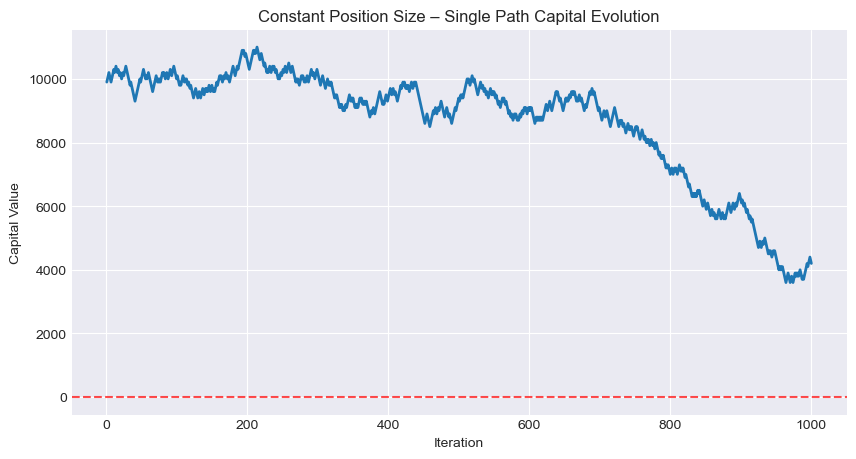

In [4]:
random.seed(42)

def trial():
    return roulette_like_trial(p_win)

wagers, values = simple_bettor(
    initial_funds=initial_funds,
    stake=stake,
    n_rounds=n_rounds,
    rng_fn=trial
)

plt.figure(figsize=(10, 5))
plt.plot(wagers, values, linewidth=2)
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Capital Value")
plt.title("Constant Position Size – Single Path Capital Evolution")
plt.show()

## 3. Monte Carlo Simulation Across Many Paths

We now simulate many independent realisations of the same process using identical parameters.

This allows us to estimate:

- Ruin probability (frequency of total capital depletion)
- Expected vs typical outcomes (mean vs median final capital)
- Distributional shape and tail risk

Monte Carlo simulation is essential here, as tail events dominate long-run risk.


In [5]:
n_bettors = 1000

final_values, broke_count = run_simulation(
    simple_bettor,
    initial_funds,
    stake,
    n_rounds,
    n_bettors=n_bettors,
    p_win=p_win,
    seed=42,
)

print("Paths resulting in capital depletion:", broke_count)
print("Ruin probability:", round(broke_count / n_bettors * 100, 2), "%")

mean_value = np.mean(final_values)
median_value = np.median(final_values)

print("Mean final capital:", round(mean_value, 2))
print("Median final capital:", round(median_value, 2))

Paths resulting in capital depletion: 11
Ruin probability: 1.1 %
Mean final capital: 7962.6
Median final capital: 8000.0


## 4. Distribution of Final Capital

The histogram below shows the distribution of final capital values across Monte Carlo paths.

Vertical lines indicate the mean and median, highlighting the skewed nature of outcomes under negative drift and the divergence between typical and average results.


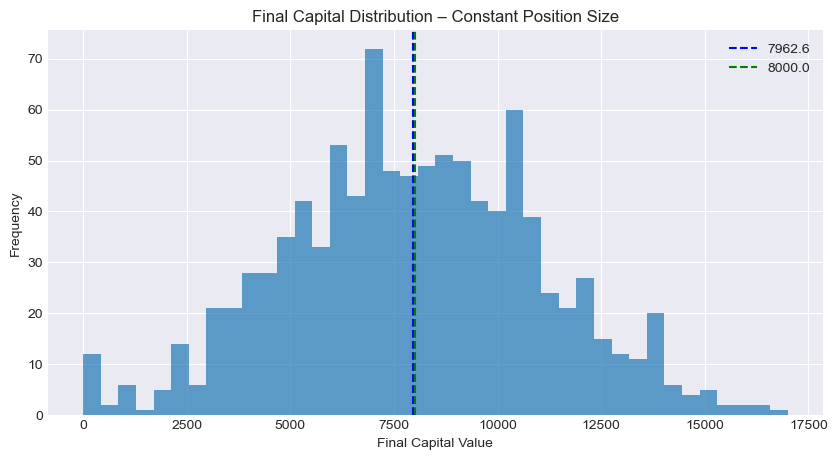

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(final_values, bins=40, alpha=0.7)
plt.axvline(mean_value, color="blue", linestyle="--", label=str(round(mean_value, 2)))
plt.axvline(median_value, color="green", linestyle="--", label=str(round(median_value, 2)))
plt.title("Final Capital Distribution – Constant Position Size")
plt.xlabel("Final Capital Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Summary

- A constant position size provides a clean baseline for analysing capital dynamics.
- Under negative expected returns, long-run capital decay is inevitable.
- Outcome distributions become increasingly dispersed as horizon lengthens.
- Even simple exposure rules exhibit non-trivial ruin probabilities.

This notebook establishes a reference point for evaluating more aggressive exposure-scaling rules, which are examined in subsequent notebooks.
